#### Load package

In [1]:
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from gensim.models import KeyedVectors #Word2Vec
from transformers import AutoTokenizer, AutoModel #Huggingface
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

#### Read the dataset

In [2]:
df = pd.read_csv(r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\AI_Human.csv\AI_Human.csv")
df.head()
texts = df["text"].tolist()
labels = df["generated"].tolist()

#### Define word embedding

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("Device:", device)

Device: cuda


In [4]:
def compute_bert_cls(texts, model_name="bert-base-uncased", max_len=256, batch_size=32):
    from transformers import BertTokenizer, BertModel
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name).to(device)
    model.eval()

    all_cls = []
    total_steps = (len(texts) + batch_size - 1) // batch_size
    for i in tqdm(range(0, len(texts), batch_size), desc="Computing [CLS] Embeddings", total=total_steps):
        batch_texts = texts[i : i+batch_size]

        inputs = tokenizer(batch_texts,
                           return_tensors='pt',
                           padding=True,
                           truncation=True,
                           max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            cls_vectors = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # (batch_size, 768)
            all_cls.extend(cls_vectors)

    return all_cls  # shape: (N, 768)

def compute_huggingface_cls(texts, model_name="bert-base-cased", max_len=256, batch_size=32):
    from transformers import AutoTokenizer, AutoModel
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    all_cls = []
    total_steps = (len(texts) + batch_size - 1) // batch_size
    for i in tqdm(range(0, len(texts), batch_size), desc="Computing [CLS] Embeddings", total=total_steps):
        batch_texts = texts[i : i+batch_size]

        inputs = tokenizer(batch_texts,
                           return_tensors='pt',
                           padding=True,
                           truncation=True,
                           max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            cls_vectors = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # (batch_size, 768)
            all_cls.extend(cls_vectors)

    return all_cls  # shape: (N, 768)


In [5]:
import torch
import numpy as np
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
from gensim.models.fasttext import load_facebook_model, load_facebook_vectors

def get_embedding(method=None,vocab=None,basic_embed_dim=512,word2vec_model_path=None,fasttext_model_path=None):
    """
    Select different embedding methods based on the parameter method.
    
    Parameters:
    ----------
    method : str
        Specify the embedding method to use, options are:
        "basic",
        "bert",
        "word2vec",
        "fasttext",
        "huggingface"
    
    basic_embed_dim : int
        Dimension of the basic embedding (if method is "basic").
    vocab : dict
        A dictionary mapping tokens to their corresponding IDs (if method is "basic").
    bert_model_name : str
        Model name for Hugging Face `BertTokenizer.from_pretrained` and `BertModel.from_pretrained` (if method is "bert")

    word2vec_model_path : str
        Path to the pre-trained Word2Vec model file (if method is "word2vec")

    fasttext_model_path : str
        Path to the pre-trained fastText model file (if method is "fasttext")

    hf_model_name : str
        Model name for Hugging Face `AutoTokenizer.from_pretrained` and `AutoModel.from_pretrained` (if method is "huggingface")

    Returns:
    ----------
    A function that can obtain embeddings for text, for example:
        embed_fn = get_embedding(method="bert")
        vector = embed_fn("Hello world!")
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    if method == "basic":
        if vocab is None:
            raise ValueError("When method='basic', please provide a vocab.")
        def basic_embed(text):
            tokens = text.split()
            indices = []
            for t in tokens:
                if t in vocab:
                    indices.append(vocab[t])
                else:
                    indices.append(1) # OOV token ID (1)
            
            indices = indices[:basic_embed_dim]
            # Pad to basic_embed_dim (512) with 0s
            if len(indices) < basic_embed_dim:
                indices += [0] * (basic_embed_dim - len(indices))
            # Return token IDs (no padding, leave it to collate_fn to handle)
            return torch.tensor(indices, dtype=torch.long)

        return basic_embed, basic_embed_dim
    
    # # Bert-based embedding
    # if method == "bert":
    #     tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    #     model = BertModel.from_pretrained(bert_model_name).to(device)
    #     embed_dim = model.config.hidden_size

    #     def bert_embed(text, max_len=512):
    #         # Directly use the tokenizer to process => automatically adds [CLS], [SEP], and converts to token_ids
    #         inputs = tokenizer(text,
    #                        return_tensors='pt',
    #                        truncation=True,
    #                        max_length=max_len).to(device)  # Move to GPU if available
    #         # Move inputs to the device
    #         inputs = {k: v.to(device) for k, v in inputs.items()}

    #         with torch.no_grad():
    #             outputs = model(**inputs)
    #             # outputs.last_hidden_state shape: (1, seq_len, 768)
    #             # Take the 0th token (i.e., [CLS]) => shape: (1, 768)
    #             cls_vec = outputs.last_hidden_state[:, 0, :]
    #             return cls_vec.cpu().numpy()

    #     return bert_embed, embed_dim

    # Word2Vec embedding
    elif method == "word2vec":
        if word2vec_model_path is None:
            raise ValueError("Please provide word2vec_model_path to load the Word2Vec model.")
        word2vec_model = KeyedVectors.load(word2vec_model_path, mmap='r')
        embed_dim = word2vec_model.vector_size
        def word2vec_embed(text):
            tokens = text.split()
            embeddings = [word2vec_model[token] for token in tokens if token in word2vec_model]
            if len(embeddings) == 0:
                return np.zeros((1, word2vec_model.vector_size), dtype=np.float32)
            return np.array(embeddings, dtype=np.float32)

        return word2vec_embed, embed_dim

    # fastText embedding
    elif method == "fasttext":
        if fasttext_model_path is None:
            raise ValueError("Please provide fasttext_model_path to load the fastText model.")
        fasttext_model = load_facebook_vectors(fasttext_model_path)
        embed_dim = fasttext_model.vector_size
        def fasttext_embed(text):
            tokens = text.split()
            embeddings = [fasttext_model[token] for token in tokens]
            if len(embeddings) == 0:
                return np.zeros((1, fasttext_model.vector_size), dtype=np.float32)
            return np.array(embeddings, dtype=np.float32)

        return fasttext_embed, embed_dim

    # Hugging Face (AutoTokenizer) embedding
    # elif method == "huggingface":
    #     tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
    #     model = AutoModel.from_pretrained(hf_model_name).to(device)
    #     embed_dim = model.config.hidden_size

    #     def hf_embed(text, max_len=512):
    #         # Directly use the tokenizer to process => automatically adds [CLS], [SEP], and converts to token_ids
    #         inputs = tokenizer(text,
    #                        return_tensors='pt',
    #                        truncation=True,
    #                        max_length=max_len).to(device)  # Move to GPU if available
    #         # Move inputs to the device
    #         inputs = {k: v.to(device) for k, v in inputs.items()}

    #         with torch.no_grad():
    #             outputs = model(**inputs)
    #             # outputs.last_hidden_state shape: (1, seq_len, 768)
    #             # Take the 0th token (i.e., [CLS]) => shape: (1, 768)
    #             cls_vec = outputs.last_hidden_state[:, 0, :]
    #             return cls_vec.cpu().numpy()

    #     return hf_embed, embed_dim

    else:
        raise ValueError(f"Unsupported embedding method: {method}")


In [98]:
vocab = {}
idx=2
for text in texts:
    for token in text.split():
        if token not in vocab:
            vocab[token] = idx
            idx += 1
vocab_size = len(vocab)
print("Vocabulary size (for basic):", vocab_size)

basic_embed, basic_embed_dim = get_embedding(method="basic",vocab=vocab)
vector=basic_embed("Hello world!")
print("Basic Embedding: ",vector) 
print("Basic Embedding shape: ",vector.shape)


Vocabulary size (for basic): 544828
Basic Embedding:  tensor([ 9223, 19656,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

In [100]:
word2vec_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\word2vec\word2vec-google-news-300.model"
word2vec_embed_fn,word2vec_embed_dim = get_embedding(method="word2vec", word2vec_model_path=word2vec_path)
vector = word2vec_embed_fn("Hello world!")
print("Word2Vec Embedding:", vector)
print("Word2Vec Embedding Dimension:", vector.shape)


Word2Vec Embedding: [[-0.05102539  0.12060547 -0.01257324  0.03088379 -0.08544922  0.0534668
  -0.13964844 -0.16308594  0.08300781  0.20507812 -0.09423828  0.15527344
  -0.00418091  0.02111816 -0.10986328  0.22460938  0.22265625  0.15917969
   0.05786133 -0.15527344  0.23046875  0.34765625  0.44335938 -0.14550781
   0.15136719  0.02209473 -0.16308594  0.2578125   0.20019531  0.06054688
  -0.0222168  -0.13183594 -0.06396484 -0.12792969  0.09814453 -0.13574219
   0.01928711  0.25195312  0.14257812  0.2421875   0.03173828 -0.17089844
   0.26171875  0.4296875   0.24804688 -0.10351562 -0.13867188 -0.14257812
  -0.20703125 -0.00860596 -0.43359375 -0.01757812  0.40234375  0.32617188
   0.33203125  0.01000977 -0.11523438 -0.12695312  0.01940918 -0.25390625
   0.00393677 -0.00344849 -0.19042969  0.05419922  0.14453125 -0.0546875
  -0.11132812  0.15136719 -0.265625    0.20019531  0.14941406  0.16601562
   0.06835938  0.00616455 -0.35742188  0.14746094  0.05761719  0.00152588
   0.12890625  0.449

In [101]:
fasttext_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\crawl-300d-2M-subword\crawl-300d-2M-subword.bin"
fasttext_embed_fn,fasttext_embed_dim = get_embedding(method="fasttext", fasttext_model_path=fasttext_path)
vector = fasttext_embed_fn("Hello world!")
print("fastText Embedding:", vector)
print("fastText Embedding Dimension:", fasttext_embed_dim)


fastText Embedding: [[ 1.81149244e-02  5.14125219e-03 -2.08850745e-02 -5.11600263e-02
  -6.18216805e-02  8.42273384e-02  1.91626009e-02 -1.73843391e-02
   1.06773581e-02 -8.78582522e-02 -6.92208260e-02 -1.01886466e-02
   7.78889796e-03 -7.75627932e-03 -8.79838504e-03 -3.26813161e-02
  -1.04001807e-02 -1.24754384e-02 -5.88071272e-02  6.38854429e-02
  -9.04164389e-02  1.32695166e-02 -3.37858573e-02  2.45712996e-02
  -7.61081204e-02  4.39338386e-03 -2.04229560e-02 -1.98551756e-03
   1.65815391e-02  4.35716286e-02 -2.84993462e-02 -6.74858540e-02
  -9.57319327e-03  1.58015247e-02 -4.22056159e-03 -2.90478580e-02
  -2.28375737e-02  2.78109908e-02  4.17162366e-02  1.83492359e-02
  -4.48604338e-02 -4.32992280e-02  1.47551461e-03  1.14149787e-02
  -1.14797186e-02  1.26050875e-01 -2.50928458e-02 -1.55853061e-02
  -8.52917284e-02  6.04228489e-02  6.57912344e-03  8.02616961e-03
   8.86745602e-02 -1.33105814e-02  5.89746125e-02  1.24461586e-02
   3.86003777e-02 -4.41966802e-02 -1.24060567e-02 -8.243

#### Define Dataset

Part A: 定義 "BasicIndexDataset" + "BasicLSTM" (for method="basic")

In [6]:
from torch.utils.data import Dataset, DataLoader

class GeneralDataset(Dataset):
    def __init__(self, texts, labels, embed_fn):
        self.texts = texts
        self.labels = labels
        self.embed_fn = embed_fn

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # 1) Get embedding (could be torch.Tensor or np.ndarray)
        x_maybe_np = self.embed_fn(text)
        
        # 2) If it's a NumPy array, convert to torch.Tensor
        if isinstance(x_maybe_np, np.ndarray):
            # Typically embedding for Word2Vec, FastText, HuggingFace, BERT is float
            x = torch.tensor(x_maybe_np, dtype=torch.float32)
        else:
            # If method="basic", `embed_fn` returns torch.LongTensor already
            x = x_maybe_np

        # 3) Convert label to tensor
        y = torch.tensor(label, dtype=torch.float32)
        
        return x, y



def general_collate_fn(batch):
    """
    batch = [ (x1, y1), (x2, y2), ... ]
      - x could be shape=(seq_len,) or (seq_len, embed_dim)
      - y is a scalar
    Returns:
      - padded_x: If basic -> (batch_size, max_seq_len)
                  If pretrained -> (batch_size, max_seq_len, embed_dim)
      - y: (batch_size,)
    """
    xs, ys = zip(*batch)

    # Check dimension to decide if "pretrained" (2D) or "basic" (1D)
    is_pretrained = (xs[0].dim() == 2)  # 2D -> pretrained, 1D -> basic

    if not is_pretrained:
        # Basic => shape=(seq_len,) => pad with 0
        lengths = [x.size(0) for x in xs]
        max_len = max(lengths)
        batch_size = len(xs)
        padded_x = torch.zeros(batch_size, max_len, dtype=torch.long)
        for i, x in enumerate(xs):
            seq_len = x.size(0)
            padded_x[i, :seq_len] = x
    else:
        # Pretrained => shape=(seq_len, embed_dim) => pad with 0
        lengths = [x.size(0) for x in xs]
        max_len = max(lengths)
        embed_dim = xs[0].size(1)
        batch_size = len(xs)
        padded_x = torch.zeros(batch_size, max_len, embed_dim, dtype=torch.float32)
        for i, x in enumerate(xs):
            seq_len = x.size(0)
            padded_x[i, :seq_len, :] = x

    ys = torch.stack(ys)  # (batch_size,)
    return padded_x, ys


In [15]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings  # shape (N, 768)
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x_np = self.embeddings[idx]        # shape = (seq_len_i, 768)
        x_tensor = torch.tensor(x_np, dtype=torch.float32)
        y_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x_tensor, y_tensor
def collate_bert_cls(batch):
    xs, ys = zip(*batch)
    x_tensor = torch.stack(xs)  # (batch_size, 768)
    # Insert the "seq_len=1" dimension so LSTM sees (batch_size, 1, 768)
    x_tensor = x_tensor.unsqueeze(1)
    
    y_tensor = torch.stack(ys)
    return x_tensor, y_tensor


In [8]:
import torch.nn as nn

class GeneralLSTM(nn.Module):
    def __init__(self, method, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.method = method
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        if self.method == "basic":
            # Learnable embedding
            self.embedding = nn.Embedding(num_embeddings=vocab_size+2,
                                          embedding_dim=embed_dim,
                                          padding_idx=0)
            self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        else:
            # Other methods already use floating-point vectors
            self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        If method=="basic" => x shape = (batch_size, seq_len) => token IDs
        Otherwise => x shape = (batch_size, seq_len, embed_dim)
        """
        if self.method == "basic":
            # Pass through the embedding layer first
            x = self.embedding(x)  # => (batch_size, seq_len, embed_dim)

        # Regardless of the method, pass through LSTM
        _, (hidden, _) = self.lstm(x)  # hidden shape=(1, batch_size, hidden_dim)
        out = self.fc(hidden.squeeze(0))  # => (batch_size, output_dim)
        return out


In [9]:
class CNNLSTM(nn.Module):
    def __init__(self, method, vocab_size, embed_dim, hidden_dim, output_dim, kernel_size=3):
        super().__init__()
        self.method = method

        if self.method == "basic":
            self.embedding = nn.Embedding(vocab_size+2, embed_dim, padding_idx=0)
        self.conv1d = nn.Conv1d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=kernel_size, padding=kernel_size // 2)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if self.method == "basic":
            x = self.embedding(x)  # (batch, seq_len, embed_dim)

        x = x.transpose(1, 2)         # (batch, embed_dim, seq_len) for Conv1d
        x = self.conv1d(x)
        x = x.transpose(1, 2)         # Back to (batch, seq_len, embed_dim)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden.squeeze(0))
        return out


In [10]:
class BiLSTM(nn.Module):
    def __init__(self, method, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.method = method

        if self.method == "basic":
            self.embedding = nn.Embedding(vocab_size+2, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Because bidirectional outputs twice the hidden_dim

    def forward(self, x):
        if self.method == "basic":
            x = self.embedding(x)

        _, (hidden, _) = self.lstm(x)
        # hidden shape: (2, batch, hidden_dim) → concatenate forward & backward
        hidden_cat = torch.cat((hidden[0], hidden[1]), dim=1)  # (batch, hidden_dim * 2)
        out = self.fc(hidden_cat)
        return out


In [11]:
def clear_gpu_memory():
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print(" GPU memory cleared.\n")
clear_gpu_memory()

 GPU memory cleared.



In [ ]:
def run_training(
    method,
    csv_path,
    model_class, 
    model_path=None,      # Relevant for "word2vec", "fasttext", "huggingface", "bert"
    vocab=None,              # Required for "basic"
    basic_embed_dim=512,     # Default dimension for "basic"
    n_epochs=5
):
    # 1) Read CSV
    df = pd.read_csv(csv_path)
    texts = df['text'].tolist()
    labels = df['generated'].tolist()

    # 2) Train/test split
    texts_train, texts_test, labels_train, labels_test = train_test_split(
        texts, labels, test_size=0.2, random_state=42
    )

    # 3) Get embedding function
    # Note: If method="basic", vocab and basic_embed_dim must be provided
    if method == "basic":
        if vocab is None:
            raise ValueError("When method='basic', vocab must be constructed first.")

        embed_fn, embed_dim = get_embedding(
            method=method,
            vocab=vocab,
            basic_embed_dim=basic_embed_dim
        )
        vocab_size = len(vocab)

    elif method == "word2vec":
        embed_fn, embed_dim = get_embedding(
            method="word2vec",
            word2vec_model_path=model_path
        )
        vocab_size = 0  # Only used for "basic"

    elif method == "fasttext":
        embed_fn, embed_dim = get_embedding(
            method="fasttext",
            fasttext_model_path=model_path
        )
        vocab_size = 0

    elif method == "huggingface":
        folder = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\huggingface"
        os.makedirs(folder, exist_ok=True)
        train_embed_path = os.path.join(folder, "train_embeds_hf.npy")
        test_embed_path  = os.path.join(folder, "test_embeds_hf.npy")

        if (not os.path.exists(train_embed_path)) or (not os.path.exists(test_embed_path)):
            print("[HuggingFace] => Precompute train & test embeddings ...")
            train_embeds = compute_huggingface_cls(texts_train, model_name=model_path, max_len=512, batch_size=32)
            test_embeds  = compute_huggingface_cls(texts_test,  model_name=model_path, max_len=512, batch_size=32)

            np.save(train_embed_path, train_embeds, allow_pickle=True)
            np.save(test_embed_path,  test_embeds, allow_pickle=True)
        else:
            print("[HuggingFace] => Loading cached embeddings from disk ...")
            train_embeds = np.load(train_embed_path, allow_pickle=True)
            test_embeds  = np.load(test_embed_path, allow_pickle=True)
            train_embeds=list(train_embeds)
            test_embeds=list(test_embeds)

        embed_dim = 768  # Hugging Face hidden size is 768
        train_dataset = EmbeddingDataset(train_embeds, labels_train)
        test_dataset  = EmbeddingDataset(test_embeds,  labels_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_bert_cls)
        test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, collate_fn=collate_bert_cls)
        vocab_size = 0

    elif method == "bert":
        folder = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\bert"
        os.makedirs(folder, exist_ok=True)
        train_embed_path = os.path.join(folder, "train_embeds_bert.npy")
        test_embed_path  = os.path.join(folder, "test_embeds_bert.npy")

        if (not os.path.exists(train_embed_path)) or (not os.path.exists(test_embed_path)):
            print("[BERT] => Precompute train & test embeddings ...")
            train_embeds = compute_bert_cls(texts_train, model_name=model_path, max_len=512, batch_size=32)
            test_embeds  = compute_bert_cls(texts_test,  model_name=model_path, max_len=512, batch_size=32)

            np.save(train_embed_path, train_embeds,allow_pickle=True)
            np.save(test_embed_path,  test_embeds, allow_pickle=True)
        else:
            print("[BERT] => Loading cached embeddings from disk ...")
            train_embeds = np.load(train_embed_path,allow_pickle=True)
            test_embeds  = np.load(test_embed_path, allow_pickle=True)
            train_embeds=list(train_embeds)
            test_embeds=list(test_embeds)

        embed_dim = 768  # BERT hidden size is 768
        # Build Dataset
        train_dataset = EmbeddingDataset(train_embeds, labels_train)
        test_dataset  = EmbeddingDataset(test_embeds,  labels_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_bert_cls)
        test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, collate_fn=collate_bert_cls)
        # No need for vocab
        vocab_size = 0

    else:
        raise ValueError(f"Unsupported method: {method}")

    print(f"[{method}] embed_dim={embed_dim}")

    if method in ["basic", "word2vec", "fasttext"]:
        # 4) Create Dataset + DataLoader
        train_dataset = GeneralDataset(texts_train, labels_train, embed_fn)
        test_dataset  = GeneralDataset(texts_test,  labels_test,  embed_fn)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=general_collate_fn)
        test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, collate_fn=general_collate_fn)

    # 5) Build model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hidden_dim = 256
    model = model_class(
        method=method,
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        output_dim=1
    ).to(device)

    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # 6) Define training/validation process
    def train_epoch(model, loader, optimizer, criterion):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc="Training", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x).squeeze(1)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        return epoch_loss / len(loader)

    def evaluate(model, loader, criterion):
        model.eval()
        epoch_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                preds = model(x).squeeze(1)
                loss = criterion(preds, y)
                epoch_loss += loss.item()

                rounded = (torch.sigmoid(preds) >= 0.5).float()
                correct += (rounded == y).sum().item()
                total += y.size(0)
        return epoch_loss / len(loader), correct / total
    clear_gpu_memory()
    # 7) Training process
    train_losses, test_losses, test_accuracies = [], [], []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print(f"[Epoch {epoch+1}/{n_epochs}] "
              f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

    return train_losses, test_losses, test_accuracies


[basic] embed_dim=512
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.3726, Test Loss: 0.0797, Test Acc: 97.28%


[Epoch 2/20] Train Loss: 0.0503, Test Loss: 0.0189, Test Acc: 99.44%


[Epoch 3/20] Train Loss: 0.0134, Test Loss: 0.0088, Test Acc: 99.82%


[Epoch 4/20] Train Loss: 0.0065, Test Loss: 0.0058, Test Acc: 99.86%


[Epoch 5/20] Train Loss: 0.0037, Test Loss: 0.0063, Test Acc: 99.86%


[Epoch 6/20] Train Loss: 0.0029, Test Loss: 0.0047, Test Acc: 99.89%


[Epoch 7/20] Train Loss: 0.0022, Test Loss: 0.0041, Test Acc: 99.91%


[Epoch 8/20] Train Loss: 0.0019, Test Loss: 0.0035, Test Acc: 99.93%


[Epoch 9/20] Train Loss: 0.0015, Test Loss: 0.0041, Test Acc: 99.92%


[Epoch 10/20] Train Loss: 0.0014, Test Loss: 0.0048, Test Acc: 99.90%


[Epoch 11/20] Train Loss: 0.0011, Test Loss: 0.0029, Test Acc: 99.93%


[Epoch 12/20] Train Loss: 0.0008, Test Loss: 0.0025, Test Acc: 99.94%


[Epoch 13/20] Train Loss: 0.0006, Test Loss: 0.0024, Test Acc: 99.94%


[Epoch 14/20] Train Loss: 0.0003, Test Loss: 0.0026, Test Acc: 99.94%


[Epoch 15/20] Train Loss: 0.0002, Test Loss: 0.0030, Test Acc: 99.92%


[Epoch 16/20] Train Loss: 0.0002, Test Loss: 0.0048, Test Acc: 99.93%


[Epoch 17/20] Train Loss: 0.0003, Test Loss: 0.0023, Test Acc: 99.95%


[Epoch 18/20] Train Loss: 0.0003, Test Loss: 0.0022, Test Acc: 99.94%


[Epoch 19/20] Train Loss: 0.0003, Test Loss: 0.0041, Test Acc: 99.93%


[Epoch 20/20] Train Loss: 0.0002, Test Loss: 0.0019, Test Acc: 99.96%


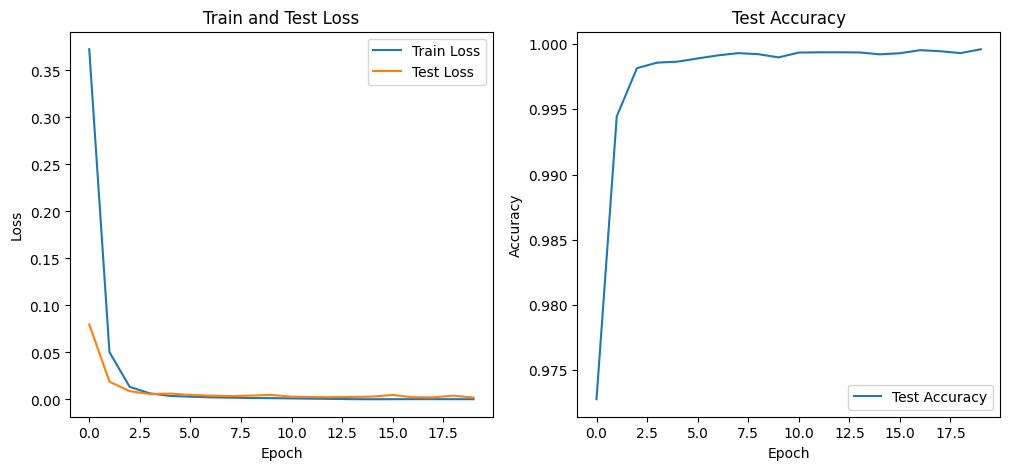

<function __main__.clear_gpu_memory()>

In [ ]:
csv_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\AI_Human.csv\AI_Human.csv"

train_losses, test_losses, test_accuracies=run_training(
    method="basic",
    model_path=None,
    model_class=GeneralLSTM,
    vocab=vocab,  
    csv_path=csv_path,
    basic_embed_dim=512,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

clear_gpu_memory()


[basic] embed_dim=512
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.2013, Test Loss: 0.0664, Test Acc: 97.91%


[Epoch 2/20] Train Loss: 0.0401, Test Loss: 0.0261, Test Acc: 99.26%


[Epoch 3/20] Train Loss: 0.0188, Test Loss: 0.0131, Test Acc: 99.66%


[Epoch 4/20] Train Loss: 0.0098, Test Loss: 0.0094, Test Acc: 99.77%


[Epoch 5/20] Train Loss: 0.0062, Test Loss: 0.0089, Test Acc: 99.77%


[Epoch 6/20] Train Loss: 0.0043, Test Loss: 0.0109, Test Acc: 99.66%


[Epoch 7/20] Train Loss: 0.0032, Test Loss: 0.0071, Test Acc: 99.82%


[Epoch 8/20] Train Loss: 0.0026, Test Loss: 0.0053, Test Acc: 99.84%


[Epoch 9/20] Train Loss: 0.0020, Test Loss: 0.0038, Test Acc: 99.89%


[Epoch 10/20] Train Loss: 0.0015, Test Loss: 0.0031, Test Acc: 99.91%


[Epoch 11/20] Train Loss: 0.0011, Test Loss: 0.0035, Test Acc: 99.90%


[Epoch 12/20] Train Loss: 0.0008, Test Loss: 0.0032, Test Acc: 99.91%


[Epoch 13/20] Train Loss: 0.0010, Test Loss: 0.0035, Test Acc: 99.93%


[Epoch 14/20] Train Loss: 0.0009, Test Loss: 0.0027, Test Acc: 99.94%


[Epoch 15/20] Train Loss: 0.0005, Test Loss: 0.0024, Test Acc: 99.94%


[Epoch 16/20] Train Loss: 0.0007, Test Loss: 0.0037, Test Acc: 99.92%


[Epoch 17/20] Train Loss: 0.0005, Test Loss: 0.0034, Test Acc: 99.94%


[Epoch 18/20] Train Loss: 0.0006, Test Loss: 0.0027, Test Acc: 99.94%


[Epoch 19/20] Train Loss: 0.0005, Test Loss: 0.0024, Test Acc: 99.93%


[Epoch 20/20] Train Loss: 0.0004, Test Loss: 0.0047, Test Acc: 99.93%


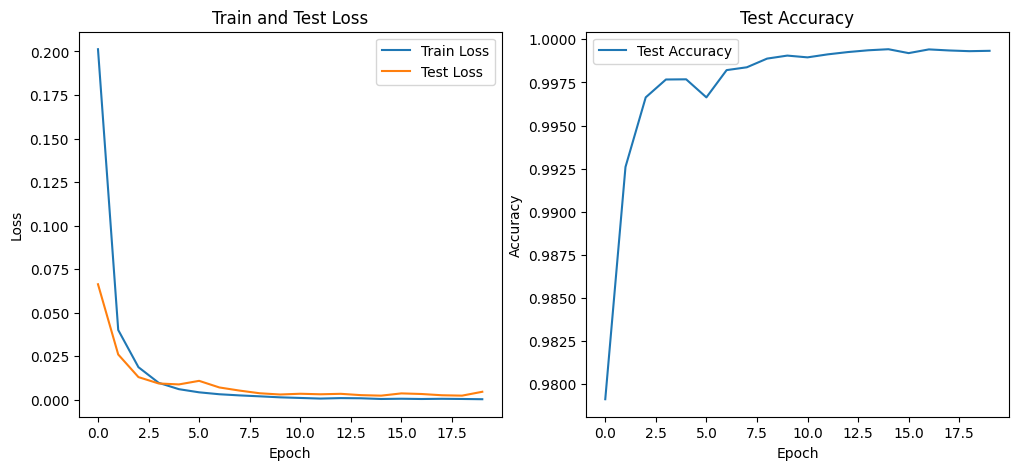

 GPU memory cleared.



In [ ]:
csv_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\AI_Human.csv\AI_Human.csv"

train_losses, test_losses, test_accuracies=run_training(
    method="basic",
    model_path=None,
    model_class=CNNLSTM,
    vocab=vocab,  
    csv_path=csv_path,
    basic_embed_dim=512,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

clear_gpu_memory()


[basic] embed_dim=512
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.0836, Test Loss: 0.0321, Test Acc: 99.11%


[Epoch 2/20] Train Loss: 0.0216, Test Loss: 0.0100, Test Acc: 99.67%


[Epoch 3/20] Train Loss: 0.0101, Test Loss: 0.0079, Test Acc: 99.75%


[Epoch 4/20] Train Loss: 0.0053, Test Loss: 0.0051, Test Acc: 99.86%


[Epoch 5/20] Train Loss: 0.0030, Test Loss: 0.0035, Test Acc: 99.89%


[Epoch 6/20] Train Loss: 0.0018, Test Loss: 0.0030, Test Acc: 99.90%


[Epoch 7/20] Train Loss: 0.0012, Test Loss: 0.0036, Test Acc: 99.91%


[Epoch 8/20] Train Loss: 0.0009, Test Loss: 0.0028, Test Acc: 99.92%


[Epoch 9/20] Train Loss: 0.0006, Test Loss: 0.0032, Test Acc: 99.92%


[Epoch 10/20] Train Loss: 0.0005, Test Loss: 0.0018, Test Acc: 99.95%


[Epoch 11/20] Train Loss: 0.0005, Test Loss: 0.0017, Test Acc: 99.95%


[Epoch 12/20] Train Loss: 0.0004, Test Loss: 0.0020, Test Acc: 99.94%


[Epoch 13/20] Train Loss: 0.0005, Test Loss: 0.0018, Test Acc: 99.95%


[Epoch 14/20] Train Loss: 0.0003, Test Loss: 0.0017, Test Acc: 99.96%


[Epoch 15/20] Train Loss: 0.0002, Test Loss: 0.0017, Test Acc: 99.96%


[Epoch 16/20] Train Loss: 0.0002, Test Loss: 0.0020, Test Acc: 99.95%


[Epoch 17/20] Train Loss: 0.0002, Test Loss: 0.0043, Test Acc: 99.89%


[Epoch 18/20] Train Loss: 0.0002, Test Loss: 0.0055, Test Acc: 99.85%


[Epoch 19/20] Train Loss: 0.0002, Test Loss: 0.0015, Test Acc: 99.96%


[Epoch 20/20] Train Loss: 0.0001, Test Loss: 0.0019, Test Acc: 99.95%


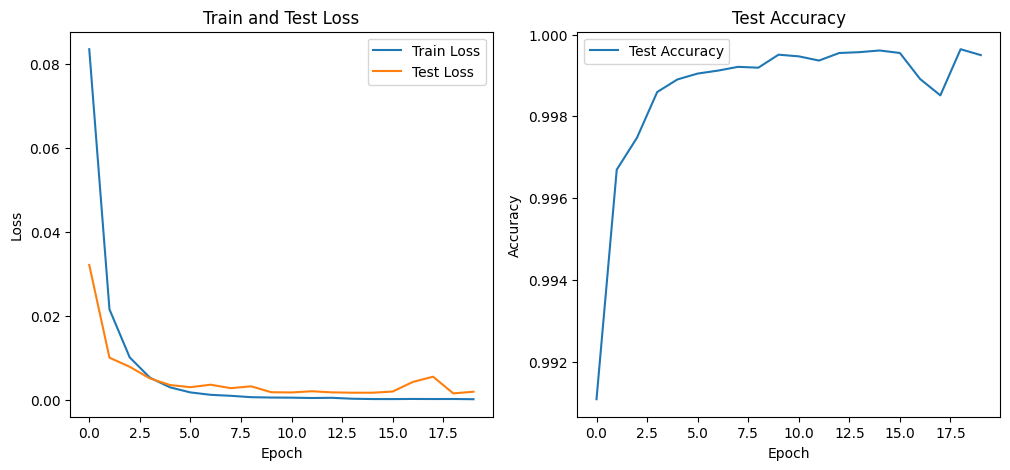

 GPU memory cleared.



In [ ]:
csv_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\AI_Human.csv\AI_Human.csv"

train_losses, test_losses, test_accuracies=run_training(
    method="basic",
    model_path=None,
    model_class=BiLSTM,
    vocab=vocab,  
    csv_path=csv_path,
    basic_embed_dim=512,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

clear_gpu_memory()


[word2vec] embed_dim=300
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.6379, Test Loss: 0.5587, Test Acc: 69.64%


[Epoch 2/20] Train Loss: 0.5918, Test Loss: 0.6562, Test Acc: 62.71%


[Epoch 3/20] Train Loss: 0.3663, Test Loss: 0.1638, Test Acc: 94.18%


[Epoch 4/20] Train Loss: 0.1665, Test Loss: 0.1178, Test Acc: 95.55%


[Epoch 5/20] Train Loss: 0.1099, Test Loss: 0.0804, Test Acc: 97.43%


[Epoch 6/20] Train Loss: 0.0787, Test Loss: 0.0615, Test Acc: 98.10%


[Epoch 7/20] Train Loss: 0.0641, Test Loss: 0.0485, Test Acc: 98.54%


[Epoch 8/20] Train Loss: 0.0474, Test Loss: 0.0550, Test Acc: 98.10%


[Epoch 9/20] Train Loss: 0.0364, Test Loss: 0.0323, Test Acc: 98.96%


[Epoch 10/20] Train Loss: 0.0289, Test Loss: 0.0239, Test Acc: 99.27%


[Epoch 11/20] Train Loss: 0.0220, Test Loss: 0.0191, Test Acc: 99.43%


[Epoch 12/20] Train Loss: 0.0173, Test Loss: 0.0152, Test Acc: 99.54%


[Epoch 13/20] Train Loss: 0.0137, Test Loss: 0.0167, Test Acc: 99.50%


[Epoch 14/20] Train Loss: 0.0108, Test Loss: 0.0134, Test Acc: 99.56%


[Epoch 15/20] Train Loss: 0.0090, Test Loss: 0.0090, Test Acc: 99.73%


[Epoch 16/20] Train Loss: 0.0072, Test Loss: 0.0103, Test Acc: 99.72%


[Epoch 17/20] Train Loss: 0.0061, Test Loss: 0.0163, Test Acc: 99.56%


[Epoch 18/20] Train Loss: 0.0051, Test Loss: 0.0149, Test Acc: 99.48%


[Epoch 19/20] Train Loss: 0.0046, Test Loss: 0.0066, Test Acc: 99.81%


[Epoch 20/20] Train Loss: 0.0039, Test Loss: 0.0084, Test Acc: 99.78%


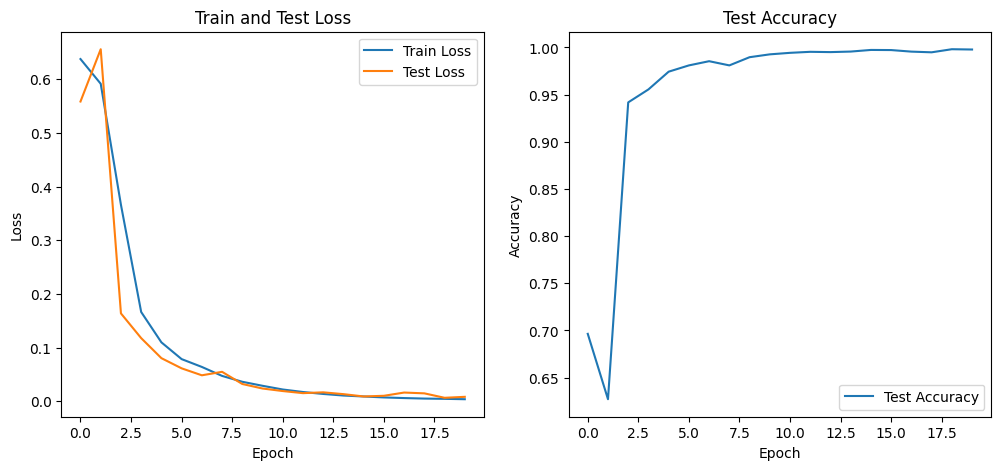

 GPU memory cleared.



In [ ]:
csv_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\AI_Human.csv\AI_Human.csv"
word2vec_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\word2vec\word2vec-google-news-300.model"

train_losses, test_losses, test_accuracies=run_training(
    method="word2vec",
    model_class=GeneralLSTM,
    model_path=word2vec_path,
    csv_path=csv_path,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[word2vec] embed_dim=300
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.3922, Test Loss: 0.1606, Test Acc: 94.51%


[Epoch 2/20] Train Loss: 0.1529, Test Loss: 0.2098, Test Acc: 91.86%


[Epoch 3/20] Train Loss: 0.0969, Test Loss: 0.0761, Test Acc: 97.61%


[Epoch 4/20] Train Loss: 0.0742, Test Loss: 0.0597, Test Acc: 98.05%


[Epoch 5/20] Train Loss: 0.0582, Test Loss: 0.0579, Test Acc: 98.36%


[Epoch 6/20] Train Loss: 0.0459, Test Loss: 0.0368, Test Acc: 98.85%


[Epoch 7/20] Train Loss: 0.0365, Test Loss: 0.0436, Test Acc: 98.66%


[Epoch 8/20] Train Loss: 0.0302, Test Loss: 0.0259, Test Acc: 99.26%


[Epoch 9/20] Train Loss: 0.0246, Test Loss: 0.0228, Test Acc: 99.31%


[Epoch 10/20] Train Loss: 0.0200, Test Loss: 0.0196, Test Acc: 99.39%


[Epoch 11/20] Train Loss: 0.0158, Test Loss: 0.0142, Test Acc: 99.59%


[Epoch 12/20] Train Loss: 0.0129, Test Loss: 0.0137, Test Acc: 99.61%


[Epoch 13/20] Train Loss: 0.0101, Test Loss: 0.0123, Test Acc: 99.67%


[Epoch 14/20] Train Loss: 0.0081, Test Loss: 0.0242, Test Acc: 99.31%


[Epoch 15/20] Train Loss: 0.0068, Test Loss: 0.0097, Test Acc: 99.73%


[Epoch 16/20] Train Loss: 0.0054, Test Loss: 0.0089, Test Acc: 99.76%


[Epoch 17/20] Train Loss: 0.0047, Test Loss: 0.0120, Test Acc: 99.69%


[Epoch 18/20] Train Loss: 0.0043, Test Loss: 0.0074, Test Acc: 99.79%


[Epoch 19/20] Train Loss: 0.0039, Test Loss: 0.0095, Test Acc: 99.74%


[Epoch 20/20] Train Loss: 0.0036, Test Loss: 0.0244, Test Acc: 99.35%


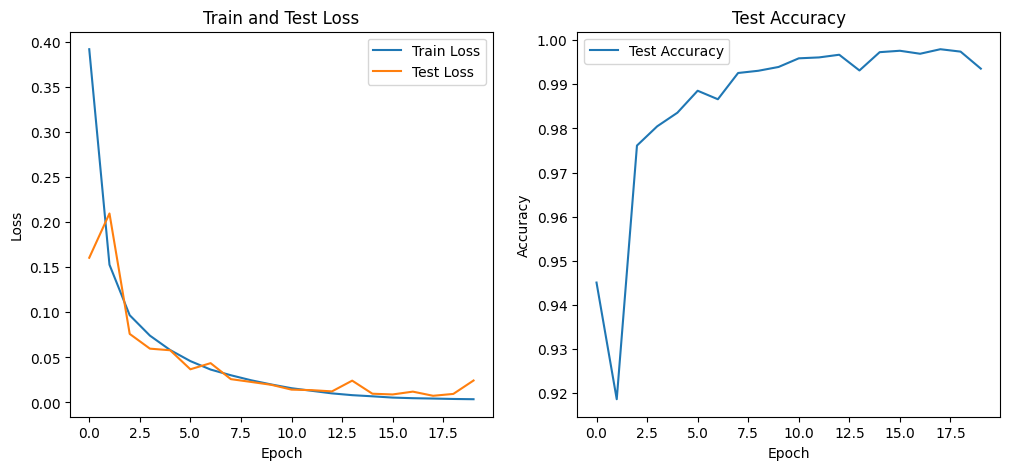

 GPU memory cleared.



In [ ]:
csv_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\AI_Human.csv\AI_Human.csv"
word2vec_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\word2vec\word2vec-google-news-300.model"

train_losses, test_losses, test_accuracies=run_training(
    method="word2vec",
    model_class=CNNLSTM,
    model_path=word2vec_path,
    csv_path=csv_path,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[word2vec] embed_dim=300
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.4943, Test Loss: 0.4106, Test Acc: 87.53%


[Epoch 2/20] Train Loss: 0.2099, Test Loss: 0.1069, Test Acc: 96.24%


[Epoch 3/20] Train Loss: 0.0752, Test Loss: 0.0865, Test Acc: 96.83%


[Epoch 4/20] Train Loss: 0.0443, Test Loss: 0.0344, Test Acc: 98.86%


[Epoch 5/20] Train Loss: 0.0281, Test Loss: 0.0225, Test Acc: 99.29%


[Epoch 6/20] Train Loss: 0.0187, Test Loss: 0.0140, Test Acc: 99.57%


[Epoch 7/20] Train Loss: 0.0130, Test Loss: 0.0123, Test Acc: 99.61%


[Epoch 8/20] Train Loss: 0.0094, Test Loss: 0.0087, Test Acc: 99.73%


[Epoch 9/20] Train Loss: 0.0066, Test Loss: 0.0074, Test Acc: 99.77%


[Epoch 10/20] Train Loss: 0.0055, Test Loss: 0.0061, Test Acc: 99.81%


[Epoch 11/20] Train Loss: 0.0043, Test Loss: 0.0074, Test Acc: 99.77%


[Epoch 12/20] Train Loss: 0.0035, Test Loss: 0.0064, Test Acc: 99.79%


[Epoch 13/20] Train Loss: 0.0029, Test Loss: 0.0052, Test Acc: 99.83%


[Epoch 14/20] Train Loss: 0.0024, Test Loss: 0.0046, Test Acc: 99.85%


[Epoch 15/20] Train Loss: 0.0022, Test Loss: 0.0059, Test Acc: 99.80%


[Epoch 16/20] Train Loss: 0.0020, Test Loss: 0.0051, Test Acc: 99.84%


[Epoch 17/20] Train Loss: 0.0017, Test Loss: 0.0044, Test Acc: 99.88%


[Epoch 18/20] Train Loss: 0.0015, Test Loss: 0.0053, Test Acc: 99.86%


[Epoch 19/20] Train Loss: 0.0017, Test Loss: 0.0044, Test Acc: 99.88%


[Epoch 20/20] Train Loss: 0.0013, Test Loss: 0.0064, Test Acc: 99.85%


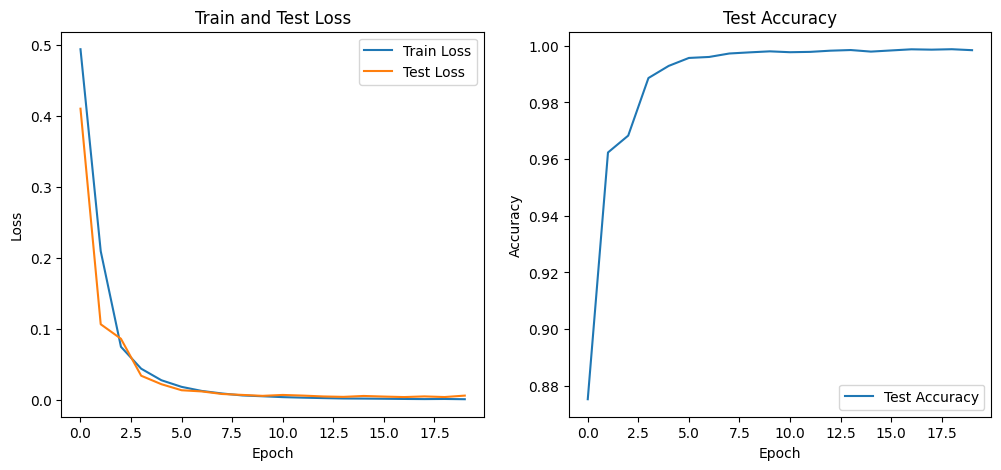

 GPU memory cleared.



In [ ]:
csv_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\AI_Human.csv\AI_Human.csv"
word2vec_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\word2vec\word2vec-google-news-300.model"

train_losses, test_losses, test_accuracies=run_training(
    method="word2vec",
    model_class=BiLSTM,
    model_path=word2vec_path,
    csv_path=csv_path,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[fasttext] embed_dim=300
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.6507, Test Loss: 0.6446, Test Acc: 62.73%


[Epoch 2/20] Train Loss: 0.6493, Test Loss: 0.6476, Test Acc: 62.78%


[Epoch 3/20] Train Loss: 0.6518, Test Loss: 0.6556, Test Acc: 62.72%


[Epoch 4/20] Train Loss: 0.5560, Test Loss: 0.1910, Test Acc: 92.81%


[Epoch 5/20] Train Loss: 0.1466, Test Loss: 0.1604, Test Acc: 93.83%


[Epoch 6/20] Train Loss: 0.0873, Test Loss: 0.0681, Test Acc: 97.65%


[Epoch 7/20] Train Loss: 0.0615, Test Loss: 0.0642, Test Acc: 97.83%


[Epoch 8/20] Train Loss: 0.0468, Test Loss: 0.0443, Test Acc: 98.46%


[Epoch 9/20] Train Loss: 0.0372, Test Loss: 0.0474, Test Acc: 98.73%


[Epoch 10/20] Train Loss: 0.0319, Test Loss: 0.0363, Test Acc: 98.72%


[Epoch 11/20] Train Loss: 0.0259, Test Loss: 0.0215, Test Acc: 99.31%


[Epoch 12/20] Train Loss: 0.0218, Test Loss: 0.0184, Test Acc: 99.40%


[Epoch 13/20] Train Loss: 0.0183, Test Loss: 0.0183, Test Acc: 99.42%


[Epoch 14/20] Train Loss: 0.3352, Test Loss: 0.0510, Test Acc: 98.29%


[Epoch 15/20] Train Loss: 0.0209, Test Loss: 0.0295, Test Acc: 99.02%


[Epoch 16/20] Train Loss: 0.0139, Test Loss: 0.0303, Test Acc: 98.84%


[Epoch 17/20] Train Loss: 0.0117, Test Loss: 0.0157, Test Acc: 99.47%


[Epoch 18/20] Train Loss: 0.0102, Test Loss: 0.0371, Test Acc: 98.88%


[Epoch 19/20] Train Loss: 0.0092, Test Loss: 0.0233, Test Acc: 99.15%


[Epoch 20/20] Train Loss: 0.0080, Test Loss: 0.0089, Test Acc: 99.74%


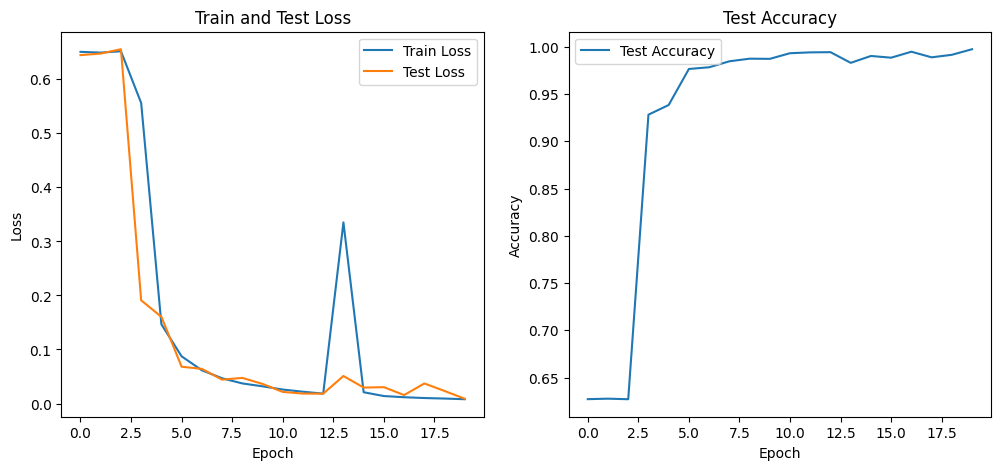

 GPU memory cleared.



In [ ]:
fasttext_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\crawl-300d-2M-subword\crawl-300d-2M-subword.bin"

train_losses, test_losses, test_accuracies=run_training(
    method="fasttext",
    model_path=fasttext_path,
    model_class=GeneralLSTM,
    csv_path=csv_path,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[fasttext] embed_dim=300
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.6485, Test Loss: 0.6433, Test Acc: 62.86%


[Epoch 2/20] Train Loss: 0.2937, Test Loss: 0.2183, Test Acc: 89.14%


[Epoch 3/20] Train Loss: 0.1532, Test Loss: 0.1174, Test Acc: 95.59%


[Epoch 4/20] Train Loss: 0.1071, Test Loss: 0.0801, Test Acc: 97.27%


[Epoch 5/20] Train Loss: 0.0772, Test Loss: 0.0856, Test Acc: 97.20%


[Epoch 6/20] Train Loss: 0.0595, Test Loss: 0.0560, Test Acc: 98.08%


[Epoch 7/20] Train Loss: 0.0457, Test Loss: 0.0372, Test Acc: 98.84%


[Epoch 8/20] Train Loss: 0.0350, Test Loss: 0.0298, Test Acc: 99.03%


[Epoch 9/20] Train Loss: 0.0281, Test Loss: 0.0241, Test Acc: 99.26%


[Epoch 10/20] Train Loss: 0.0227, Test Loss: 0.0197, Test Acc: 99.42%


[Epoch 11/20] Train Loss: 0.0184, Test Loss: 0.0175, Test Acc: 99.46%


[Epoch 12/20] Train Loss: 0.0155, Test Loss: 0.0173, Test Acc: 99.49%


[Epoch 13/20] Train Loss: 0.0125, Test Loss: 0.0165, Test Acc: 99.50%


[Epoch 14/20] Train Loss: 0.0100, Test Loss: 0.0121, Test Acc: 99.60%


[Epoch 15/20] Train Loss: 0.0078, Test Loss: 0.0108, Test Acc: 99.64%


[Epoch 16/20] Train Loss: 0.0067, Test Loss: 0.0081, Test Acc: 99.77%


[Epoch 17/20] Train Loss: 0.0052, Test Loss: 0.0112, Test Acc: 99.66%


[Epoch 18/20] Train Loss: 0.0045, Test Loss: 0.0074, Test Acc: 99.78%


[Epoch 19/20] Train Loss: 0.0039, Test Loss: 0.0073, Test Acc: 99.81%


[Epoch 20/20] Train Loss: 0.0034, Test Loss: 0.0067, Test Acc: 99.82%


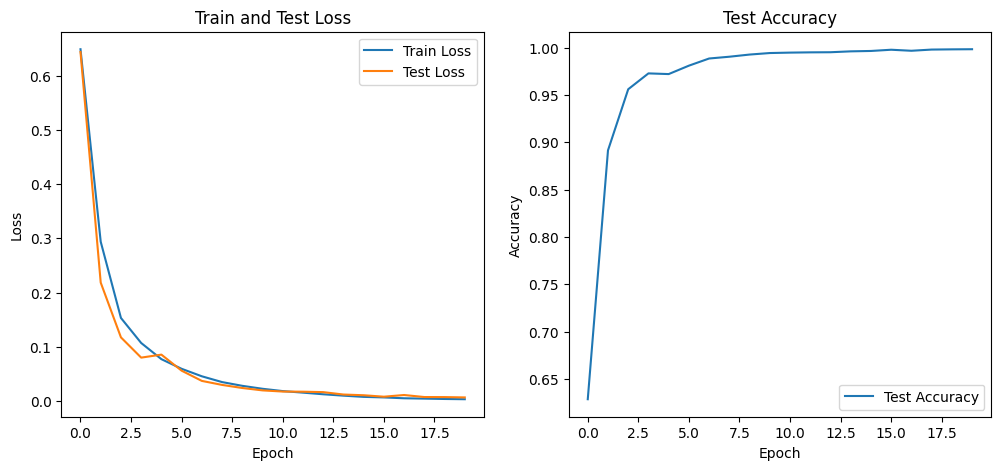

 GPU memory cleared.



In [ ]:
fasttext_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\crawl-300d-2M-subword\crawl-300d-2M-subword.bin"

train_losses, test_losses, test_accuracies=run_training(
    method="fasttext",
    model_path=fasttext_path,
    model_class=CNNLSTM,
    csv_path=csv_path,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[fasttext] embed_dim=300
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.3367, Test Loss: 0.2053, Test Acc: 93.39%


[Epoch 2/20] Train Loss: 0.1785, Test Loss: 0.1100, Test Acc: 96.29%


[Epoch 3/20] Train Loss: 0.1441, Test Loss: 0.1029, Test Acc: 96.62%


[Epoch 4/20] Train Loss: 0.1146, Test Loss: 0.0770, Test Acc: 97.33%


[Epoch 5/20] Train Loss: 0.0872, Test Loss: 0.0693, Test Acc: 97.81%


[Epoch 6/20] Train Loss: 0.0869, Test Loss: 0.1426, Test Acc: 95.60%


[Epoch 7/20] Train Loss: 0.0800, Test Loss: 0.0574, Test Acc: 98.17%


[Epoch 8/20] Train Loss: 0.1946, Test Loss: 0.2570, Test Acc: 89.46%


[Epoch 9/20] Train Loss: 0.1491, Test Loss: 0.0560, Test Acc: 98.12%


[Epoch 10/20] Train Loss: 0.0574, Test Loss: 0.0383, Test Acc: 98.80%


[Epoch 11/20] Train Loss: 0.0588, Test Loss: 0.0416, Test Acc: 98.69%


[Epoch 12/20] Train Loss: 0.0889, Test Loss: 0.0757, Test Acc: 97.37%


[Epoch 13/20] Train Loss: 0.0708, Test Loss: 0.0572, Test Acc: 98.07%


[Epoch 14/20] Train Loss: 0.0461, Test Loss: 0.0335, Test Acc: 98.89%


[Epoch 15/20] Train Loss: 0.0377, Test Loss: 0.0432, Test Acc: 98.59%


[Epoch 16/20] Train Loss: 0.0390, Test Loss: 0.0319, Test Acc: 98.96%


[Epoch 17/20] Train Loss: 0.0295, Test Loss: 0.0300, Test Acc: 99.00%


[Epoch 18/20] Train Loss: 0.0244, Test Loss: 0.0237, Test Acc: 99.23%


[Epoch 19/20] Train Loss: 0.0186, Test Loss: 0.0147, Test Acc: 99.55%


[Epoch 20/20] Train Loss: 0.0150, Test Loss: 0.0128, Test Acc: 99.59%


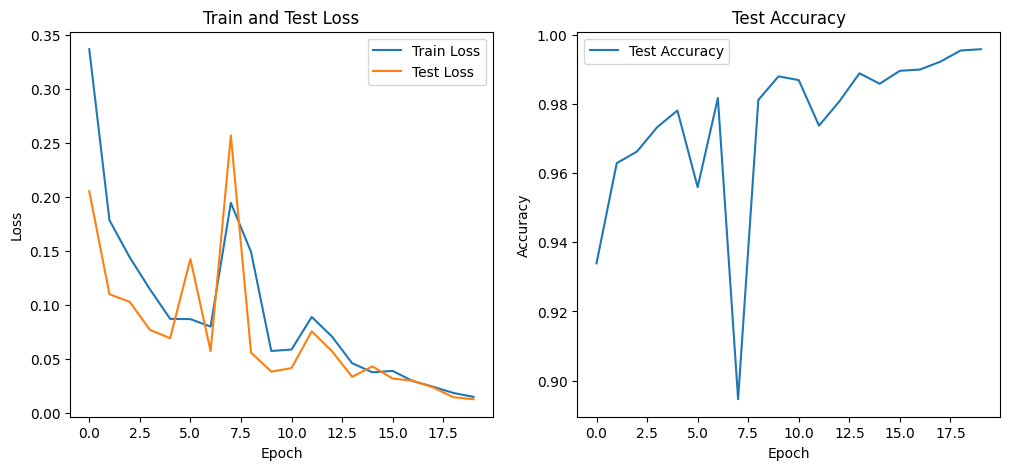

 GPU memory cleared.



In [ ]:
fasttext_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\Embedding\crawl-300d-2M-subword\crawl-300d-2M-subword.bin"

train_losses, test_losses, test_accuracies=run_training(
    method="fasttext",
    model_path=fasttext_path,
    model_class=BiLSTM,
    csv_path=csv_path,
    n_epochs=20
)
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[BERT] => Loading cached embeddings from disk ...
[bert] embed_dim=768
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.0589, Test Loss: 0.0340, Test Acc: 98.89%


[Epoch 2/20] Train Loss: 0.0287, Test Loss: 0.0252, Test Acc: 99.20%


[Epoch 3/20] Train Loss: 0.0209, Test Loss: 0.0194, Test Acc: 99.42%


[Epoch 4/20] Train Loss: 0.0163, Test Loss: 0.0152, Test Acc: 99.53%


[Epoch 5/20] Train Loss: 0.0130, Test Loss: 0.0156, Test Acc: 99.50%


[Epoch 6/20] Train Loss: 0.0104, Test Loss: 0.0118, Test Acc: 99.62%


[Epoch 7/20] Train Loss: 0.0085, Test Loss: 0.0107, Test Acc: 99.65%


[Epoch 8/20] Train Loss: 0.0070, Test Loss: 0.0089, Test Acc: 99.71%


[Epoch 9/20] Train Loss: 0.0058, Test Loss: 0.0081, Test Acc: 99.74%


[Epoch 10/20] Train Loss: 0.0048, Test Loss: 0.0098, Test Acc: 99.67%


[Epoch 11/20] Train Loss: 0.0042, Test Loss: 0.0076, Test Acc: 99.74%


[Epoch 12/20] Train Loss: 0.0035, Test Loss: 0.0074, Test Acc: 99.75%


[Epoch 13/20] Train Loss: 0.0029, Test Loss: 0.0075, Test Acc: 99.75%


[Epoch 14/20] Train Loss: 0.0026, Test Loss: 0.0070, Test Acc: 99.76%


[Epoch 15/20] Train Loss: 0.0022, Test Loss: 0.0094, Test Acc: 99.70%


[Epoch 16/20] Train Loss: 0.0020, Test Loss: 0.0092, Test Acc: 99.74%


[Epoch 17/20] Train Loss: 0.0018, Test Loss: 0.0070, Test Acc: 99.77%


[Epoch 18/20] Train Loss: 0.0016, Test Loss: 0.0064, Test Acc: 99.79%


[Epoch 19/20] Train Loss: 0.0015, Test Loss: 0.0054, Test Acc: 99.83%


[Epoch 20/20] Train Loss: 0.0014, Test Loss: 0.0056, Test Acc: 99.82%


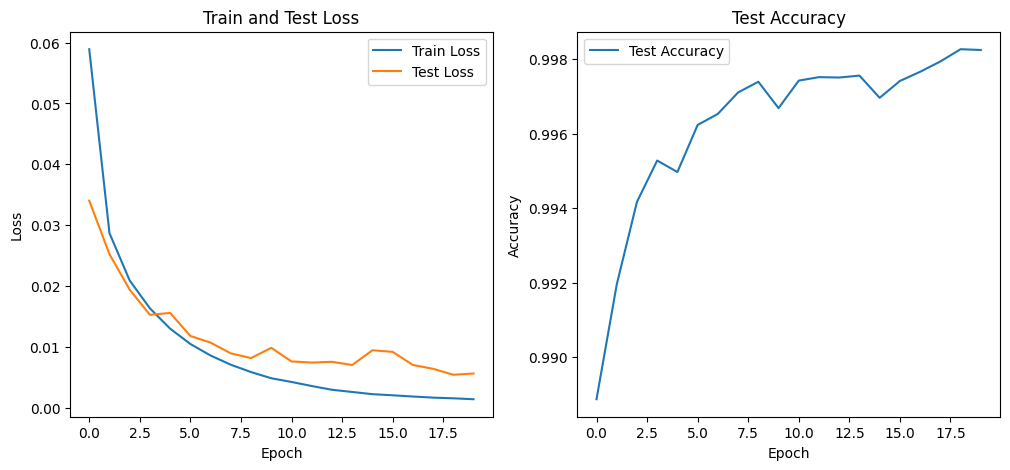

 GPU memory cleared.



In [16]:
csv_path = r"C:\Users\Kevin\Desktop\master\RNN&Transformer\HW1\AI_Human.csv\AI_Human.csv"
train_losses, test_losses, test_accuracies=run_training(
    method="bert",
    model_path="bert-base-uncased",
    model_class=GeneralLSTM,
    csv_path=csv_path,
    n_epochs=20
)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[BERT] => Loading cached embeddings from disk ...
[bert] embed_dim=768
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.0553, Test Loss: 0.0532, Test Acc: 98.14%


[Epoch 2/20] Train Loss: 0.0312, Test Loss: 0.0256, Test Acc: 99.15%


[Epoch 3/20] Train Loss: 0.0235, Test Loss: 0.0218, Test Acc: 99.32%


[Epoch 4/20] Train Loss: 0.0184, Test Loss: 0.0197, Test Acc: 99.37%


[Epoch 5/20] Train Loss: 0.0151, Test Loss: 0.0160, Test Acc: 99.49%


[Epoch 6/20] Train Loss: 0.0127, Test Loss: 0.0179, Test Acc: 99.38%


[Epoch 7/20] Train Loss: 0.0108, Test Loss: 0.0127, Test Acc: 99.56%


[Epoch 8/20] Train Loss: 0.0093, Test Loss: 0.0105, Test Acc: 99.68%


[Epoch 9/20] Train Loss: 0.0077, Test Loss: 0.0111, Test Acc: 99.64%


[Epoch 10/20] Train Loss: 0.0068, Test Loss: 0.0095, Test Acc: 99.70%


[Epoch 11/20] Train Loss: 0.0059, Test Loss: 0.0120, Test Acc: 99.61%


[Epoch 12/20] Train Loss: 0.0053, Test Loss: 0.0095, Test Acc: 99.67%


[Epoch 13/20] Train Loss: 0.0046, Test Loss: 0.0087, Test Acc: 99.71%


[Epoch 14/20] Train Loss: 0.0043, Test Loss: 0.0112, Test Acc: 99.66%


[Epoch 15/20] Train Loss: 0.0039, Test Loss: 0.0090, Test Acc: 99.69%


[Epoch 16/20] Train Loss: 0.0034, Test Loss: 0.0091, Test Acc: 99.70%


[Epoch 17/20] Train Loss: 0.0033, Test Loss: 0.0074, Test Acc: 99.77%


[Epoch 18/20] Train Loss: 0.0032, Test Loss: 0.0075, Test Acc: 99.75%


[Epoch 19/20] Train Loss: 0.0026, Test Loss: 0.0120, Test Acc: 99.64%


[Epoch 20/20] Train Loss: 0.0026, Test Loss: 0.0087, Test Acc: 99.73%


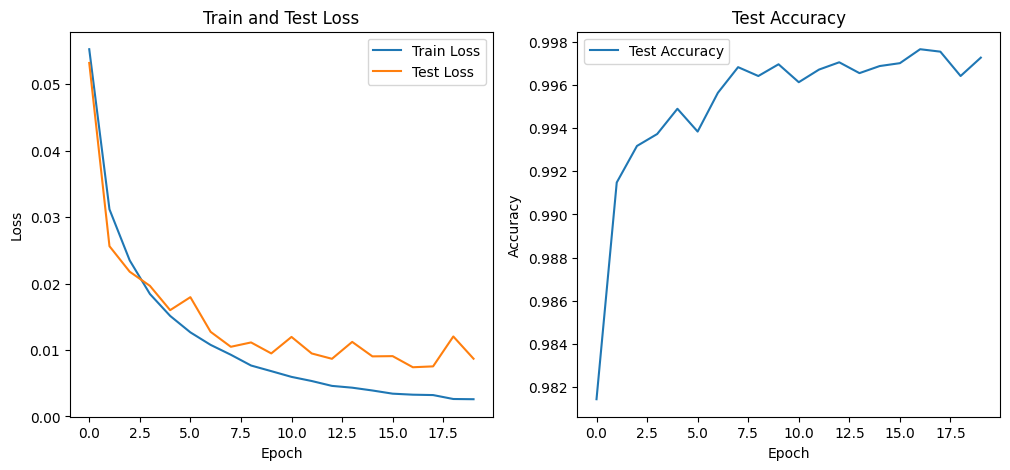

 GPU memory cleared.



In [17]:
train_losses, test_losses, test_accuracies=run_training(
    method="bert",
    model_path="bert-base-uncased",
    model_class=CNNLSTM,
    csv_path=csv_path,
    n_epochs=20
)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[BERT] => Loading cached embeddings from disk ...
[bert] embed_dim=768
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.0536, Test Loss: 0.0314, Test Acc: 98.99%


[Epoch 2/20] Train Loss: 0.0258, Test Loss: 0.0211, Test Acc: 99.35%


[Epoch 3/20] Train Loss: 0.0185, Test Loss: 0.0218, Test Acc: 99.31%


[Epoch 4/20] Train Loss: 0.0142, Test Loss: 0.0181, Test Acc: 99.41%


[Epoch 5/20] Train Loss: 0.0113, Test Loss: 0.0121, Test Acc: 99.61%


[Epoch 6/20] Train Loss: 0.0090, Test Loss: 0.0096, Test Acc: 99.68%


[Epoch 7/20] Train Loss: 0.0072, Test Loss: 0.0106, Test Acc: 99.65%


[Epoch 8/20] Train Loss: 0.0060, Test Loss: 0.0085, Test Acc: 99.71%


[Epoch 9/20] Train Loss: 0.0049, Test Loss: 0.0081, Test Acc: 99.73%


[Epoch 10/20] Train Loss: 0.0042, Test Loss: 0.0079, Test Acc: 99.75%


[Epoch 11/20] Train Loss: 0.0035, Test Loss: 0.0076, Test Acc: 99.74%


[Epoch 12/20] Train Loss: 0.0030, Test Loss: 0.0077, Test Acc: 99.74%


[Epoch 13/20] Train Loss: 0.0026, Test Loss: 0.0079, Test Acc: 99.74%


[Epoch 14/20] Train Loss: 0.0023, Test Loss: 0.0065, Test Acc: 99.80%


[Epoch 15/20] Train Loss: 0.0020, Test Loss: 0.0107, Test Acc: 99.64%


[Epoch 16/20] Train Loss: 0.0017, Test Loss: 0.0098, Test Acc: 99.67%


[Epoch 17/20] Train Loss: 0.0017, Test Loss: 0.0069, Test Acc: 99.79%


[Epoch 18/20] Train Loss: 0.0014, Test Loss: 0.0100, Test Acc: 99.69%


[Epoch 19/20] Train Loss: 0.0014, Test Loss: 0.0064, Test Acc: 99.80%


[Epoch 20/20] Train Loss: 0.0013, Test Loss: 0.0059, Test Acc: 99.81%


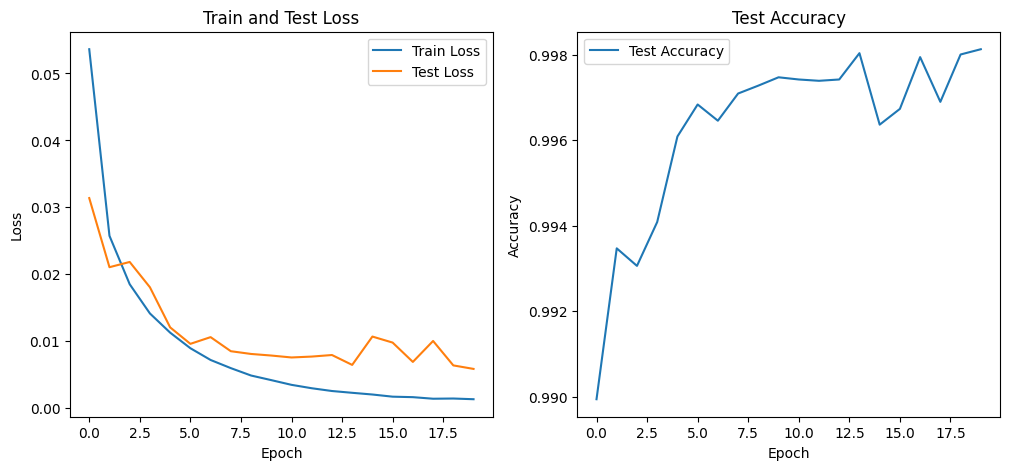

 GPU memory cleared.



In [18]:
train_losses, test_losses, test_accuracies=run_training(
    method="bert",
    model_path="bert-base-uncased",
    model_class=BiLSTM,
    csv_path=csv_path,
    n_epochs=20
)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()
clear_gpu_memory()

[HuggingFace] => Precompute train & test embeddings ...


Computing Embeddings: 100%|██████████| 3046/3046 [04:16<00:00, 11.85it/s]


[huggingface] embed_dim=768
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.1545, Test Loss: 0.1146, Test Acc: 95.74%


[Epoch 2/20] Train Loss: 0.1012, Test Loss: 0.1080, Test Acc: 95.99%


[Epoch 3/20] Train Loss: 0.0868, Test Loss: 0.0807, Test Acc: 97.14%


[Epoch 4/20] Train Loss: 0.0775, Test Loss: 0.0710, Test Acc: 97.48%


[Epoch 5/20] Train Loss: 0.0705, Test Loss: 0.0652, Test Acc: 97.69%


[Epoch 6/20] Train Loss: 0.0644, Test Loss: 0.0631, Test Acc: 97.76%


[Epoch 7/20] Train Loss: 0.0594, Test Loss: 0.0622, Test Acc: 97.78%


[Epoch 8/20] Train Loss: 0.0551, Test Loss: 0.0579, Test Acc: 97.98%


[Epoch 9/20] Train Loss: 0.0516, Test Loss: 0.0515, Test Acc: 98.16%


[Epoch 10/20] Train Loss: 0.0484, Test Loss: 0.0490, Test Acc: 98.31%


[Epoch 11/20] Train Loss: 0.0452, Test Loss: 0.0523, Test Acc: 98.12%


[Epoch 12/20] Train Loss: 0.0427, Test Loss: 0.0455, Test Acc: 98.46%


[Epoch 13/20] Train Loss: 0.0403, Test Loss: 0.0451, Test Acc: 98.41%


[Epoch 14/20] Train Loss: 0.0378, Test Loss: 0.0437, Test Acc: 98.49%


[Epoch 15/20] Train Loss: 0.0357, Test Loss: 0.0399, Test Acc: 98.65%


[Epoch 16/20] Train Loss: 0.0338, Test Loss: 0.0400, Test Acc: 98.63%


[Epoch 17/20] Train Loss: 0.0321, Test Loss: 0.0575, Test Acc: 97.96%


[Epoch 18/20] Train Loss: 0.0305, Test Loss: 0.0379, Test Acc: 98.68%


[Epoch 19/20] Train Loss: 0.0288, Test Loss: 0.0396, Test Acc: 98.63%


[Epoch 20/20] Train Loss: 0.0274, Test Loss: 0.0431, Test Acc: 98.48%


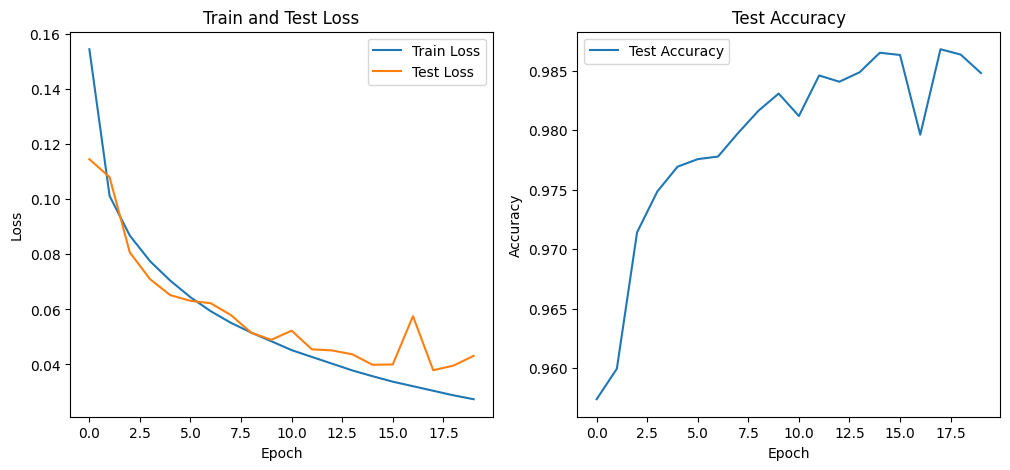

 GPU memory cleared.



In [114]:

train_losses, test_losses, test_accuracies=run_training(
    method="huggingface",
    model_path="bert-base-cased",
    model_class=GeneralLSTM,
    csv_path=csv_path,
    n_epochs=20
)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

clear_gpu_memory()

[HuggingFace] => Loading cached embeddings from disk ...
[huggingface] embed_dim=768
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.1404, Test Loss: 0.1785, Test Acc: 93.10%


[Epoch 2/20] Train Loss: 0.0994, Test Loss: 0.0850, Test Acc: 96.93%


[Epoch 3/20] Train Loss: 0.0862, Test Loss: 0.0970, Test Acc: 96.48%


[Epoch 4/20] Train Loss: 0.0767, Test Loss: 0.0663, Test Acc: 97.63%


[Epoch 5/20] Train Loss: 0.0686, Test Loss: 0.0869, Test Acc: 96.71%


[Epoch 6/20] Train Loss: 0.0620, Test Loss: 0.0596, Test Acc: 97.86%


[Epoch 7/20] Train Loss: 0.0558, Test Loss: 0.0762, Test Acc: 97.20%


[Epoch 8/20] Train Loss: 0.0514, Test Loss: 0.0486, Test Acc: 98.27%


[Epoch 9/20] Train Loss: 0.0470, Test Loss: 0.0549, Test Acc: 98.00%


[Epoch 10/20] Train Loss: 0.0436, Test Loss: 0.0611, Test Acc: 97.74%


[Epoch 11/20] Train Loss: 0.0399, Test Loss: 0.0408, Test Acc: 98.55%


[Epoch 12/20] Train Loss: 0.0368, Test Loss: 0.0465, Test Acc: 98.43%


[Epoch 13/20] Train Loss: 0.0341, Test Loss: 0.0519, Test Acc: 98.24%


[Epoch 14/20] Train Loss: 0.0313, Test Loss: 0.0418, Test Acc: 98.48%


[Epoch 15/20] Train Loss: 0.0294, Test Loss: 0.0364, Test Acc: 98.77%


[Epoch 16/20] Train Loss: 0.0268, Test Loss: 0.0374, Test Acc: 98.67%


[Epoch 17/20] Train Loss: 0.0250, Test Loss: 0.0386, Test Acc: 98.73%


[Epoch 18/20] Train Loss: 0.0232, Test Loss: 0.0377, Test Acc: 98.65%


[Epoch 19/20] Train Loss: 0.0212, Test Loss: 0.0325, Test Acc: 98.89%


[Epoch 20/20] Train Loss: 0.0197, Test Loss: 0.0415, Test Acc: 98.58%


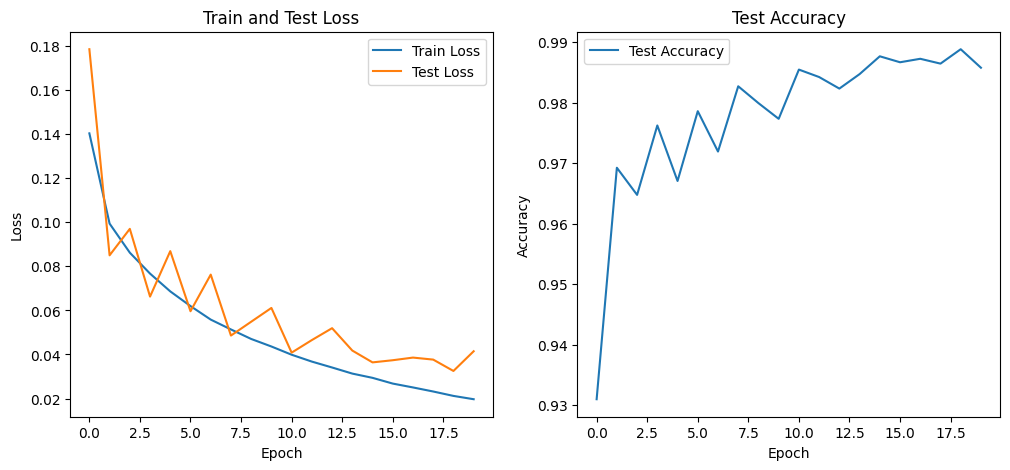

 GPU memory cleared.



In [115]:

train_losses, test_losses, test_accuracies=run_training(
    method="huggingface",
    model_path="bert-base-cased",
    model_class=CNNLSTM,
    csv_path=csv_path,
    n_epochs=20
)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

clear_gpu_memory()

[HuggingFace] => Loading cached embeddings from disk ...
[huggingface] embed_dim=768
 GPU memory cleared.



[Epoch 1/20] Train Loss: 0.1488, Test Loss: 0.1010, Test Acc: 96.39%


[Epoch 2/20] Train Loss: 0.0977, Test Loss: 0.0866, Test Acc: 96.91%


[Epoch 3/20] Train Loss: 0.0833, Test Loss: 0.0741, Test Acc: 97.40%


[Epoch 4/20] Train Loss: 0.0733, Test Loss: 0.0676, Test Acc: 97.67%


[Epoch 5/20] Train Loss: 0.0660, Test Loss: 0.0627, Test Acc: 97.82%


[Epoch 6/20] Train Loss: 0.0601, Test Loss: 0.0590, Test Acc: 97.93%


[Epoch 7/20] Train Loss: 0.0555, Test Loss: 0.0522, Test Acc: 98.19%


[Epoch 8/20] Train Loss: 0.0513, Test Loss: 0.0538, Test Acc: 98.09%


[Epoch 9/20] Train Loss: 0.0478, Test Loss: 0.0637, Test Acc: 97.73%


[Epoch 10/20] Train Loss: 0.0445, Test Loss: 0.0453, Test Acc: 98.42%


[Epoch 11/20] Train Loss: 0.0416, Test Loss: 0.0547, Test Acc: 98.08%


[Epoch 12/20] Train Loss: 0.0385, Test Loss: 0.0576, Test Acc: 97.83%


[Epoch 13/20] Train Loss: 0.0364, Test Loss: 0.0417, Test Acc: 98.52%


[Epoch 14/20] Train Loss: 0.0342, Test Loss: 0.0379, Test Acc: 98.69%


[Epoch 15/20] Train Loss: 0.0324, Test Loss: 0.0360, Test Acc: 98.78%


[Epoch 16/20] Train Loss: 0.0304, Test Loss: 0.0375, Test Acc: 98.69%


[Epoch 17/20] Train Loss: 0.0286, Test Loss: 0.0384, Test Acc: 98.64%


[Epoch 18/20] Train Loss: 0.0270, Test Loss: 0.0343, Test Acc: 98.78%


[Epoch 19/20] Train Loss: 0.0253, Test Loss: 0.0348, Test Acc: 98.76%


[Epoch 20/20] Train Loss: 0.0238, Test Loss: 0.0382, Test Acc: 98.68%


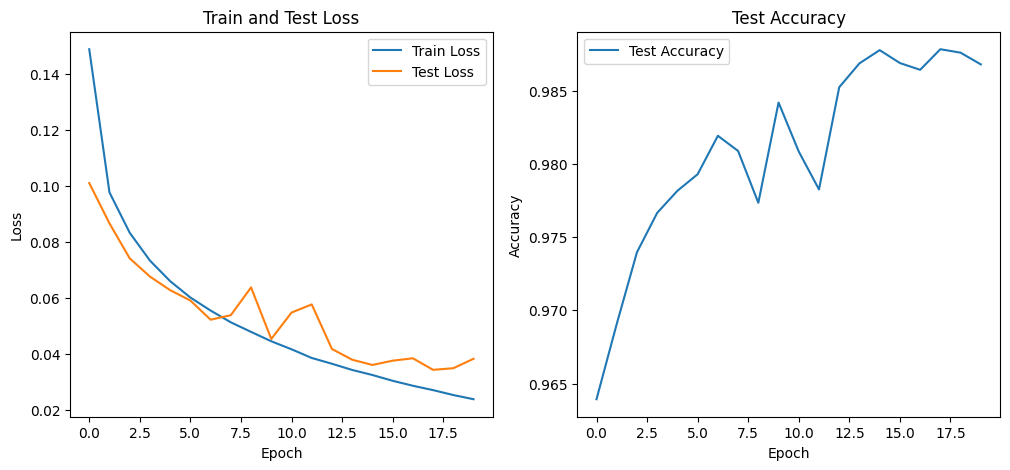

 GPU memory cleared.



In [116]:

train_losses, test_losses, test_accuracies=run_training(
    method="huggingface",
    model_path="bert-base-cased",
    model_class=BiLSTM,
    csv_path=csv_path,
    n_epochs=20
)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

clear_gpu_memory()